## Tutorial - Georastertools

Georastertools provides satellite image processing functions written in Python, based on *rasterio* and *geopandas* libraries. It includes a CLI (Command Line Interface) and a Python API that we will introduce in this tutorial.

Georastertools gives access to the following tools:

- **Radioindice** to compute radiometric indices such as NDVI, NDWI, NDBI, etc.
- **Timeseries** to generate a temporal sequence by computing temporal derivatives between two images
- **Tilling** to split an image into tiles based on a given geometry
- **Zonalstats** to compute zonal statistics on a specified geometries
- **Filter** to apply filters such as median, sum, mean, and adaptive gaussian
- **Hillshade** to simulate cast shadows for a given sun elevation


### Installation 

To install Georastertools, you can use the following commands in your terminal :

```bash
conda create -n env_name
conda activate env_name
conda install python=3.8.13 libgdal=3.5.0
pip install georastertools --no-binary rasterio
```

This will create a conda environment in your machine and install the required versions of *python* and *libgdal*. It then install *georastertools* and *rasterio* with the *--no-binary* option.

### Python API

The Python API of Georastertools allows to activate each tool and to extend their functionalities. The methods are all named with the following pattern *with_\<something\>* and return the current instance so that the methods can be chained. The method *eolab.rastertools.Rastertool.process_files* allows to process several files can be processed at the same time

Here, we present a slightly more advanced example, we define our own radiometric index and compute it with the Radioindice class. 

#### Exemple : Compute a user-defined indice

In [2]:
from eolab.georastertools import Radioindice
from eolab.georastertools.product import BandChannel
from eolab.georastertools.processing import RadioindiceProcessing
import numpy as np

data_dir = '../tests/tests_data/'

We define the Normalized Difference Snow Index (NDSI) in a function that takes a numpy.ndarray as input and returns the computed NDSI in a numpy.ndarray.

The Normalized Difference Snow Index (NDSI) is calculated using the following formula:

$$\text{NDSI} = \frac{\text{Green Band} - \text{SWIR Band}}{\text{Green Band} + \text{SWIR Band}}$$

Then, we instantiate a RadioindiceProcessing object by giving the indice function to the *algo* parameter. In our case, we use *ndsi_fct*.
We then specify its input channels (i.e. the bands used to compute the NDSI) with the *with_channels* method.

In [3]:
def ndsi_fct(bands : np.ndarray) -> np.ndarray :
    """
    Computes the NDSI of the input image
    """
    ndsi =  (bands[0] - bands[1]) / (bands[0] + bands[1])

    return ndsi

ndsi = RadioindiceProcessing(name = "ndsi", algo = ndsi_fct).with_channels([BandChannel.green, BandChannel.swir])

In case the indice function is not in the scope of your project, you can import it and use it in the RadioindiceProcessing intantiation as follows  : 

```python
from path_of_py_file import your_function
RadioindiceProcessing(name = "your_indice_name", algo = your_function)
```

To compute the indice, we start by intantiating *tool*, a Radioindice object, with a list of RadioindiceProcessing objects containing the indices we want to compute. In our case, we use a list of one element, containing the previously created RadioindiceProcessing object *ndsi*.


We then configure the output directory and our region of interest. The line *outputs = tool.process_files(inputfiles)* compute the NDSI of the given images and saves the output, please ensure that the output directory already exists in your machine.

In [5]:
inputfiles = [data_dir + "SENTINEL2A_20180928-105515-685_L2A_T30TYP_D.zip",data_dir + "SENTINEL2B_20181023-105107-455_L2A_T30TYP_D.zip"]


tool = Radioindice(indices = [ndsi])
tool.with_output("output_radi", merge=True)
tool.with_roi(data_dir + "COMMUNE_32001.shp")
outputs = tool.process_files(inputfiles)

ndsi: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.08it/s]


### Command Line Interface

The CLI of Georastertools enables users to use the differents tools directly from the terminal without needing to write additional code. The generated files are automatically dowloaded on your machine.

The following command lists all the options that can be given to the CLI of Georastertools.

In [6]:
%%bash
rio georastertools --help

Usage: rio georastertools [OPTIONS] COMMAND [ARGS]...

  Main entry point for the `georastertools` Command Line Interface.

  The `georastertools` CLI provides tools for raster processing and analysis
  and allows configurable data handling, parallel processing, and debugging
  support.

  Logging:

      - INFO level (`-v`) gives detailed step information.

      - DEBUG level (`-vv`) offers full debug-level tracing.

  Environment Variables:

      - `RASTERTOOLS_NOTQDM`: If the log level is above INFO, sets this to
      disable progress bars.

      - `RASTERTOOLS_MAXWORKERS`: If `max_workers` is set, it defines the max
      workers for georastertools.

Options:
  -t, --rastertype PATH  JSON file defining additional raster types of input
                         files
  --max_workers INTEGER  Maximum number of workers for parallel processing. If
                         not given, it will default to the number of
                         processors on the machine. When all process

#### Exemple 1 : Compute zonal statistics

The zonalstats tool computes zonal statistics for a given input raster. The statistics are computed inside zones defined by a vector file, or, on the entire raster if no vector file is provided. It is also possible to generate charts to visualize the computed statistics.

The tool supports the computation of various statistics, including:
- Minimum and maximum
- Range
- Mean and standard deviation
- Percentile
- Median and Median absolute deviation
- Count, for all pixels, no data and valid pixels
- Sum
- Majority and minority, most and least frequent value
- Unique values
- ...
                              
To generate the zonalstatistics of a raster, we can provide different parameters that can be displayed with the following command :

In [7]:
%%bash
rio georastertools zonalstats --help

Usage: rio georastertools zonalstats [OPTIONS] INPUTS...

  Compute zonal statistics of a raster image.

  Available statistics are: min, max, range, mean, std, percentile_x (x in [0,
  100]), median, mad, count, valid, nodata, sum, majority, minority, unique.

  By default, only the first band is computed unless specified otherwise.

  Arguments:

      inputs TEXT

      Raster files to process. You can provide a single filewith extension
      ".lst" (e.g. "zonalstats.lst") that lists the input files to process
      (one input file per line in .lst)

Options:
  -o, --output TEXT           Output directory to store results (by default
                              current directory)
  -f, --format TEXT           Output format of the results when input
                              geometries are provided (by default ESRI
                              Shapefile). Possible values are ESRI Shapefile,
                              GeoJSON, CSV, GPKG, GML
  -g, --geometry TEXT         Li

The following example computes the statistics of the blue band of a Sentinel-2B image. The vector file that contains the statistical values calculated for each geometry is automatically saved in the "output_zonalstats" directory.

In [9]:
%%bash
rio georastertools zs -o output_zonalstats -f GeoJSON -g ../tests/tests_data/COMMUNE_32xxx.geojson --stats min --stats max --stats mean --stats std tuto_data/S2B_T30TYP_20241021T105009_B02_20m.jp2

To access the computed statistics, it is possible to open the generated file on QGIS. Then, open its attribute table by clicking on the icon : <img src="img/icon.png" alt="" width=30/>

The following table contains the results obtained:


<div style="text-align: center;">
    <img src="img/table_zs_full.png" alt="" width="1000"/>
</div>

If the provided input image does not cover the entire vector file, statistics can be computed only for the geometries that are fully covered by the image by adding the --within option. This option ensure that the statistics obtained cover the whole region and are accurate. 

<div style="text-align: center;">
    <img src="img/within_zs_geom.png" alt="" width="400"/>
</div>

In [10]:
%%bash
rio georastertools zs -o output_zonalstats -f GeoJSON -g ../tests/tests_data/COMMUNE_32xxx.geojson --stats min --stats max --stats mean --stats std --within ../tests/tests_data/SENTINEL2A_20180928-105515-685_L2A_T30TYP_D-ndvi.tif

The generated table now contains the statististics of only the two geometries that are contained in the image.

<div style="text-align: center;">
    <img src="img/within_zs_table.png" alt="" width="1000"/>
</div>

To compute the number of pixels corresponding to specific values, for example in a classified image, the *--categorical* option can be used.

In the following exemple we use zonalstats on a classification of Geneva from the 21-10-2023, with labels indicating clouds, water, land, and cloud shadows.

In [11]:
%%bash
rio georastertools zs -o output_zonalstats -f GeoJSON --categorical tuto_data/labeled_img_regular.tif

We obtain the following table, that contains the occurences of each class in the input image.

<div style="text-align: center;">
    <img src="img/zs_cat_table.png" alt="" width="600"/>
</div>


#### Exemple 2 : Compute a time series and plotting its reflectance

Georastertools can generate time series between two raster images. The sequence of rasters is created using linear interpolation of every pixel of the input images.

If one of the inputs contains missing data, the interpolation enables to fill the gaps in all the rasters of the sequence.

If the start (or end) dates are before (or after) the dates of the input rasters, the corresponding generated raster will contain the values of the first (or last) input raster and may contain the same gaps as the input raster.

We start by computing NDVI images using *radioindice* to give them as an input to the *timeseries* tool.

In [12]:
%%bash
rio georastertools radioindice -o tuto_data --ndvi ../tests/tests_data/S2A_MSIL2A_20190116T105401_N0211_R051_T30TYP_20190116T120806.zip
rio georastertools radioindice -o tuto_data --ndvi ../tests/tests_data/S2B_MSIL1C_20191008T105029_N0208_R051_T30TYP_20191008T125041.zip

We rename the obtained NDVI images.

In [13]:
import os

new_raw_s2a = 'tuto_data/SENTINEL2A_20190116-105515-685_L2A_T30TYP_D-ndvi.tif'
new_raw_s2b = 'tuto_data/SENTINEL2B_20191008-105107-455_L2A_T30TYP_D-ndvi.tif'

os.rename('tuto_data/S2A_MSIL2A_20190116T105401_N0211_R051_T30TYP_20190116T120806-ndvi.tif', new_raw_s2a)
os.rename('tuto_data/S2B_MSIL1C_20191008T105029_N0208_R051_T30TYP_20191008T125041-ndvi.tif', new_raw_s2b)

The computed NDVI rasters are bigger than already available NDVI rasters due to additional NA pixels. We need crop the computed rasters to the other rasters' coordinates.

In [14]:
# Crop NA Values so the rasters all have the same size
import rasterio
from rasterio.mask import mask

def crop2raster(to_crop : str, raster_ref : str):
    '''
    Crop the to_crop raster to the raster_ref raster's coordinates
    '''
    # Get the coordinates of the reference raster
    with rasterio.open(raster_ref) as src:
        minx, miny, maxx, maxy = src.bounds
        nodata = src.nodata

        # Mask the image with the reference raster bounds
        polygon = [{'type': 'Polygon', 'coordinates': [[(minx, miny),(maxx, miny),(maxx, maxy),(minx, maxy)]]}]

    # Open the raster to crop
    with rasterio.open(to_crop) as rst_2crop:
        image_data = rst_2crop.read(1) 

        # Crop the raster
        out_image,out_transform = mask(rst_2crop, polygon, crop=True)

    # Save the cropped image
    with rasterio.open(to_crop, 'w', driver='GTiff',
                       height=out_image.shape[1], width=out_image.shape[2],
                       count=1, dtype=out_image.dtype, crs=rst_2crop.crs, nodata=nodata,
                       transform=out_transform) as dst:
        dst.write(out_image)

        
crop2raster(to_crop = new_raw_s2a, raster_ref = data_dir + 'SENTINEL2B_20181023-105107-455_L2A_T30TYP_D-ndvi.tif')
crop2raster(to_crop = new_raw_s2b, raster_ref = data_dir + 'SENTINEL2B_20181023-105107-455_L2A_T30TYP_D-ndvi.tif')

To generate a timeseries with the CLI of Georastertools, we can provide different parameters that can be displayed with the following command : 

In [15]:
%%bash
rio georastertools timeseries --help

Usage: rio georastertools timeseries [OPTIONS] INPUTS...

  Generate a timeseries of images (without gaps) from a set of input images.
  Data not present in the input images (e.g., missing images for specific
  dates or masked data) are interpolated (with linear interpolation) so that
  all gaps in the timeseries are filled.

  This command is useful for generating continuous timeseries data, even when
  some input images are missing or contain masked values.

  Arguments:

  inputs TEXT

      Input file to process (e.g. Sentinel2 L2A MAJA from THEIA). You can
      provide a single file with extension ".lst" (e.g. "speed.lst") that
      lists the input files to process (one input file per line in .lst).

Options:
  -o, --output TEXT           Output directory to store results (by default
                              current directory)
  -s, --start_date TEXT       Start date of the timeseries to generate in the
                              following format: yyyy-MM-dd
  -e, --end_

In the following example, we compute the time series between four Sentinel-2 NDVI images from 2018-09-28 to 2019-10-08. The step between two consecutive images is 10 days and the images are processed using a window size of 512 x 512 pixels.

The processed files are automatically saved in the *output_timeseries* directory.

At least two input rasters must be provided to the *timeseries* tool, but additional rasters can be included if required. In our case, we provide four Sentinel-2 NDVI images.

In [17]:
%%bash
rio georastertools timeseries ../tests/tests_data/SENTINEL2A_20180928-105515-685_L2A_T30TYP_D-ndvi.tif ../tests/tests_data/SENTINEL2B_20181023-105107-455_L2A_T30TYP_D-ndvi.tif tuto_data/SENTINEL2A_20190116-105515-685_L2A_T30TYP_D-ndvi.tif tuto_data/SENTINEL2B_20191008-105107-455_L2A_T30TYP_D-ndvi.tif -o output_timeseries -s 2018-09-28 -e 2019-10-08 -p 10 -ws 512

To plot the NDVI evolution of a pixel across time, we open the obtained rasters and store the values of an agricultural field pixel in a pandas DataFrame.

In [18]:
import pandas as pd

plt_data = []

for file in os.listdir('output_timeseries'):
    with rasterio.open('output_timeseries/' + file) as src:
        if file.split('.')[-1] == 'tif' :
            rst_data = src.read(1) 
            plt_data.append({'date': file.split('_')[1].split('-')[0], 'reflectance' : rst_data[278,177]})
            
df = pd.DataFrame(plt_data)

#Sort the dataframe by dates
df = df.sort_values("date")

#Sort the dataframe by dates
df["date"] = pd.to_datetime(df["date"], format = '%Y%m%d')

# Display the DataFrame
print(df)

         date  reflectance
4  2018-09-28     0.447849
23 2018-10-08     0.508156
24 2018-10-18     0.568464
0  2018-10-28     0.604654
25 2018-11-07     0.616775
3  2018-11-17     0.628846
20 2018-11-27     0.640917
11 2018-12-07     0.652988
1  2018-12-17     0.665058
26 2018-12-27     0.677129
37 2019-01-06     0.689200
33 2019-01-16     0.701271
32 2019-01-26     0.689642
29 2019-02-05     0.678013
17 2019-02-15     0.666383
5  2019-02-25     0.654754
34 2019-03-07     0.643125
18 2019-03-17     0.631495
28 2019-03-27     0.619866
21 2019-04-06     0.608285
7  2019-04-16     0.596656
8  2019-04-26     0.585027
22 2019-05-06     0.573398
6  2019-05-16     0.561768
14 2019-05-26     0.550139
9  2019-06-05     0.538510
10 2019-06-15     0.526880
15 2019-06-25     0.515251
30 2019-07-05     0.503622
36 2019-07-15     0.491993
35 2019-07-25     0.480363
19 2019-08-04     0.468734
12 2019-08-14     0.457105
27 2019-08-24     0.445475
31 2019-09-03     0.433846
2  2019-09-13     0.422217
1

We store the value of the pixel from the images that were used as inputs for the timeseries tool in another pandas.DataFrame.

In [19]:
raw_flist = [new_raw_s2a, data_dir + 'SENTINEL2B_20181023-105107-455_L2A_T30TYP_D-ndvi.tif', data_dir + 'SENTINEL2A_20180928-105515-685_L2A_T30TYP_D-ndvi.tif', new_raw_s2b]

plt_raw = []
for file in raw_flist:
    with rasterio.open(file) as src:
        rst_data = src.read(1) 
        plt_raw.append({'date': file.split('_')[2].split('-')[0], 'reflectance' : rst_data[278,177]})
            
df_raw = pd.DataFrame(plt_raw)

#Sort the dataframe by dates
df_raw = df_raw.sort_values("date")

#Convert str date to datetime format
df_raw["date"] = pd.to_datetime(df_raw["date"], format = '%Y%m%d')

# Display the DataFrame
print(df_raw)

        date  reflectance
2 2018-09-28     0.447849
1 2018-10-23     0.598618
0 2019-01-16     0.701271
3 2019-10-08     0.393144


We use matplotlib.pyplot to plot the reflectances, please pip install matplotlib in your conda environment before running the cell. The red dots indicates the reflectances of the images given to *timeseries* as inputs and the blue dots the reflectances of the interpolated rasters.

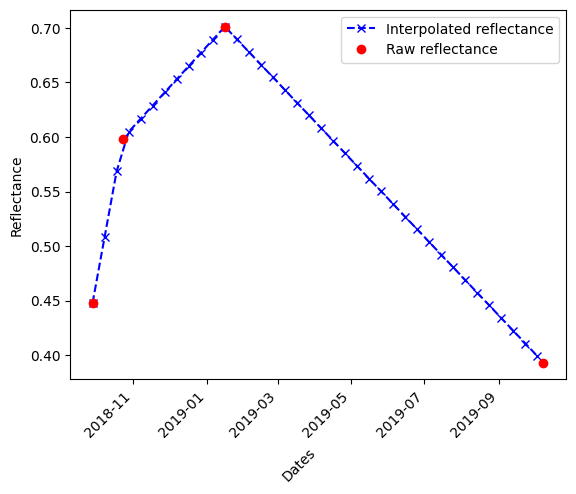

In [20]:
import matplotlib.pyplot as plt

#Reflectances of interpolated images
plt.plot(df["date"], df["reflectance"], '--bx', label='Interpolated reflectance')
#Reflectance of raw images
plt.plot(df_raw["date"], df_raw["reflectance"], 'ro', label='Raw reflectance')
plt.xticks(rotation=45, ha='right')
plt.ylabel(ylabel='Reflectance')
plt.xlabel(xlabel='Dates', rotation=45, ha='right')
plt.legend()